In [1]:
import pandas as pd
import numpy as np
import statistics
import sklearn.metrics
import warnings
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os
import random as rn
warnings.filterwarnings("ignore")

In [2]:
def get_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    num_correct_ann= annotation_df[annotation_df[correct_id_col]==annotation_df[predicted_id_col]].shape[0]
    acc=num_correct_ann/annotation_df.shape[0]
    return acc

In [3]:
def get_balanced_accuracy_verbose(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        print(cell_type)
        num_cells =cell_type_sub.shape[0]
        print("predicted cell ID")
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        print(perc)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    print("balanced accuracy:")
    print(balanced_accuracy)
    return balanced_accuracy

In [4]:
def get_balanced_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        num_cells =cell_type_sub.shape[0]
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    return balanced_accuracy

In [5]:
def get_cluster_accuracy(annotation_df, cluster_id_column ='clust',correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    correc_ann_counter=0
    annotation_df = annotation_df.groupby(cluster_id_column).filter(lambda x: len(x) > 10)
    cluster_ids =sorted(set(annotation_df[cluster_id_column]))
    for cluster_id in cluster_ids:
        cluster_sub = annotation_df[annotation_df[cluster_id_column]==cluster_id]   
        clust_real_id_counts = cluster_sub[correct_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_real_id = clust_real_id_counts.iloc[np.lexsort((clust_real_id_counts.index, -clust_real_id_counts.values))].index[0]
        clust_predicted_id_counts = cluster_sub[predicted_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_predicted_id = clust_predicted_id_counts.iloc[np.lexsort((clust_predicted_id_counts.index, -clust_predicted_id_counts.values))].index[0]
        if clust_real_id == clust_predicted_id:
            correc_ann_counter += 1
        else:
            continue
    clust_accuracy= correc_ann_counter/len(cluster_ids)
    return clust_accuracy

In [6]:
def get_cohens_kappa_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    cohens_kappa_score= sklearn.metrics.cohen_kappa_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(cohens_kappa_score)

In [7]:
def get_F1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest 
        # then convert df labels to binary classification tasks
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        #cell_type_sub = cell_type_sub[[correct_id_col, predicted_id_col]]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        F1_cell_type = sklearn.metrics.f1_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        F1_list.append(F1_cell_type)
    return(F1_list)

In [8]:
def get_macroF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID', label_list=None):
    if label_list ==None:
        label_list  = annotation_df[correct_id_col].value_counts().index   
    macroF1_score = sklearn.metrics.f1_score(annotation_df[correct_id_col], annotation_df[predicted_id_col],average='macro', labels=label_list)
    return(macroF1_score)


In [9]:
def get_medianF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_scores = get_F1_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianF1_score = statistics.median(F1_scores)
    return(medianF1_score)

In [10]:
def get_precision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        precision_cell_type = sklearn.metrics.precision_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        precision_list.append(precision_cell_type)
    return(precision_list)

In [11]:
def get_medianPrecision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_scores = get_precision_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(precision_scores)
    return(medianPrecision_score)

In [12]:
def get_recall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        recall_cell_type = sklearn.metrics.recall_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        recall_list.append(recall_cell_type)
    return(recall_list)

In [13]:
def get_medianRecall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_scores = get_recall_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(recall_scores)
    return(medianPrecision_score)

In [14]:
def get_adjusted_rand_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    adjusted_rand_score= sklearn.metrics.adjusted_rand_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(adjusted_rand_score)

In [15]:
def get_mathews_corr_coef_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    matthews_corrcoef_score= sklearn.metrics.matthews_corrcoef(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(matthews_corrcoef_score)

In [16]:
def get_common_cells(*dataframes):
    df_cell_list = [v.index for v in dataframes]
    common_cells= list(set.intersection(*map(set,df_cell_list)))
    return(common_cells)

In [17]:
def get_combined_annotations_df_for_common_cells(*frames, common_cells, cell_ID_column = "cell_IDs"):
    if not frames:
        return None
    if len(frames) == 1:
        return frames[0]
    out = frames[0]
    out = out.loc[common_cells,]
    for df in frames[1:]:
        out = out.merge(df.loc[common_cells,], on=cell_ID_column)
    return out

In [18]:
def plot_performance_metrics(df , colors=None, labels = None, y_min = 0.0, frame_color = 'gray', frame_width = 0.5, x_label_rotation = 45, tick_size = 14,legend_fontsize = 12,
                            legend_labels = None, legend_loc = 'upper center', legend_bbox_to_anchor=(0.5, -0.2), legend_ncol=4, save=False, save_path=None):

    # Default values
    default_colors = ['#5E0B8A', '#00A7E1', '#BDDA57', '#FF8C00']
    default_labels = ['accuracy', 'balanced \naccuracy','cluster \naccuracy', 'macro \nF1', 'median \nF1',
                      'median \nprecision', 'median \nrecall','MCC', 'ARI', "Cohen's \nkappa"]
    default_legend_labels =['scATAcat', 'Seurat label transfer', 'Cellcano', 'EpiAnno']

    # Use default if None is passed
    colors = default_colors if colors is None else colors
    labels = default_labels if labels is None else labels
    legend_labels = default_legend_labels if legend_labels is None else legend_labels
  
    df.columns = labels
    df.index = legend_labels
    
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42

    n_bins = 100  # Increase this number for a smoother gradient
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)
    ax = df.T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12, colormap=cmap)
    ax.set_ylim(ymin=y_min)
    # Change plot frame to gray and adjust linewidth
    spine_color = 'gray'
    linewidth = frame_width # Adjust the linewidth as needed
    for spine in ax.spines.values():
        spine.set_color(spine_color)
        spine.set_linewidth(linewidth)
    ax.legend(legend_labels,fontsize=legend_fontsize, loc=legend_loc, bbox_to_anchor=legend_bbox_to_anchor,
          fancybox=False, shadow=False, ncol=legend_ncol, frameon=False)
    plt.xticks(rotation=x_label_rotation)
    plt.tick_params(axis='both', which='major', labelsize=tick_size)

    if save == False:
        plt.show()
    else:
        if save_path == None:
            print("specify the save_path directory")
        else:
            plt.savefig(save_path, bbox_inches='tight', transparent=True)

In [19]:
paper_metadata = pd.read_csv("../../../data/Morabito2021_brainCortex_snATAC/05_cell_annotations/cell_type_annotations.csv", index_col=0,)

In [20]:
paper_metadata.index=paper_metadata['Barcode']
paper_metadata = paper_metadata[["Barcode", "Cell.Type"]]
paper_metadata.index.name = None
paper_metadata.columns = ["cell_IDs", "cell_type"]

In [21]:
paper_metadata

,cell_IDs,cell_type
AAACGAAAGACGACTG-1,AAACGAAAGACGACTG-1,ODC
AAACGAAAGAGACTCG-1,AAACGAAAGAGACTCG-1,EX
AAACGAAAGATCACCT-1,AAACGAAAGATCACCT-1,ODC
AAACGAAAGGGAAATG-1,AAACGAAAGGGAAATG-1,ODC
AAACGAAAGGTCGGTA-1,AAACGAAAGGTCGGTA-1,ODC
...,...,...
TTTGTGTGTGGATTTC-1,TTTGTGTGTGGATTTC-1,ODC
TTTGTGTTCACGTGTA-1,TTTGTGTTCACGTGTA-1,MG
TTTGTGTTCGTGGAAG-1,TTTGTGTTCGTGGAAG-1,ODC
TTTGTGTTCTAGCAGT-1,TTTGTGTTCTAGCAGT-1,ASC


In [22]:
paper_metadata['cell_type'].unique()

array(['ODC', 'EX', 'MG', 'ASC', 'PER.END', 'INH', 'OPC'], dtype=object)

from paper: 
ASC, astrocytes; EX, excitatory neurons; INH, inhibitory neurons; MG, microglia; ODC, oligodendrocytes; OPC, oligodendrocyte progenitor cells; PER/END, pericytes/endothelial cells

In [23]:
paper_metadata_rename_dict = {"ODC":"OLIG",
                              "INH":"GABA",
                              "EX":"GLU",
                              "ASC":"MGAS",
                              "OPC":"OLIG",
                              "MG":"MGAS",  
                              "PER.END":"PER/END"}

In [24]:
paper_metadata_rename_dict


{'ODC': 'OLIG',
 'INH': 'GABA',
 'EX': 'GLU',
 'ASC': 'MGAS',
 'OPC': 'OLIG',
 'MG': 'MGAS',
 'PER.END': 'PER/END'}

In [25]:
paper_metadata['ground_truth_annotations_simplified'] = paper_metadata["cell_type"].replace(paper_metadata_rename_dict)
paper_metadata.index.name = None
paper_metadata.columns=["cell_IDs", "ground_truth_annotations","ground_truth_annotations_simplified" ]
paper_metadata

,cell_IDs,ground_truth_annotations,ground_truth_annotations_simplified
AAACGAAAGACGACTG-1,AAACGAAAGACGACTG-1,ODC,OLIG
AAACGAAAGAGACTCG-1,AAACGAAAGAGACTCG-1,EX,GLU
AAACGAAAGATCACCT-1,AAACGAAAGATCACCT-1,ODC,OLIG
AAACGAAAGGGAAATG-1,AAACGAAAGGGAAATG-1,ODC,OLIG
AAACGAAAGGTCGGTA-1,AAACGAAAGGTCGGTA-1,ODC,OLIG
...,...,...,...
TTTGTGTGTGGATTTC-1,TTTGTGTGTGGATTTC-1,ODC,OLIG
TTTGTGTTCACGTGTA-1,TTTGTGTTCACGTGTA-1,MG,MGAS
TTTGTGTTCGTGGAAG-1,TTTGTGTTCGTGGAAG-1,ODC,OLIG
TTTGTGTTCTAGCAGT-1,TTTGTGTTCTAGCAGT-1,ASC,MGAS


### seurat annotations

In [26]:
seurat_labelTransfer_annotations = pd.read_csv("../../../results/Fig8-Corces2020_brain_scATAC/Fig8-apply_seurat_label_transfer/Corces2020_seurat_label_transfer_annotations.csv", index_col = 0)
seurat_labelTransfer_annotations["cell_IDs"] = seurat_labelTransfer_annotations.index
seurat_labelTransfer_annotations.head()

,predicted_cell_type,cell_IDs
AAACGAAAGCAGAGCT-1,Inh,AAACGAAAGCAGAGCT-1
AAACGAAAGGACCGAT-1,Exc,AAACGAAAGGACCGAT-1
AAACGAAAGTCGTATC-1,Inh,AAACGAAAGTCGTATC-1
AAACGAAAGTCTCGAT-1,Inh,AAACGAAAGTCTCGAT-1
AAACGAAAGTCTGGGA-1,Oligo,AAACGAAAGTCTGGGA-1


In [27]:
seurat_labelTransfer_annotations.predicted_cell_type.value_counts()

predicted_cell_type
Exc      7365
Oligo    1888
Inh       519
Astro     510
OPC       490
Name: count, dtype: int64

In [28]:
seurat_annotations_and_simplified_dict = {"Oligo":"OLIG",
                              "Inh":"GABA",
                              "Microglia":"MGAS",
                              "OPC":"OLIG",
                              "Astro":"MGAS",
                              "Exc":"GLU"}

In [29]:
seurat_labelTransfer_annotations['seurat_annotations_simp'] =list(seurat_labelTransfer_annotations["predicted_cell_type"].map(seurat_annotations_and_simplified_dict))
seurat_labelTransfer_annotations.columns=["label_transfer_annotations", "cell_IDs", "label_transfer_annotations_simplified"]

In [30]:
seurat_labelTransfer_annotations

,label_transfer_annotations,cell_IDs,label_transfer_annotations_simplified
AAACGAAAGCAGAGCT-1,Inh,AAACGAAAGCAGAGCT-1,GABA
AAACGAAAGGACCGAT-1,Exc,AAACGAAAGGACCGAT-1,GLU
AAACGAAAGTCGTATC-1,Inh,AAACGAAAGTCGTATC-1,GABA
AAACGAAAGTCTCGAT-1,Inh,AAACGAAAGTCTCGAT-1,GABA
AAACGAAAGTCTGGGA-1,Oligo,AAACGAAAGTCTGGGA-1,OLIG
...,...,...,...
TTTGTGTTCCTCATTA-1,Oligo,TTTGTGTTCCTCATTA-1,OLIG
TTTGTGTTCGGTCGAC-1,Exc,TTTGTGTTCGGTCGAC-1,GLU
TTTGTGTTCTCCCTTT-1,Exc,TTTGTGTTCTCCCTTT-1,GLU
TTTGTGTTCTGCTACC-1,Exc,TTTGTGTTCTGCTACC-1,GLU


### scATAcat annotations

In [31]:
scATAcat_annotations = pd.read_csv("../../../results/Fig8-Morabito2021_brainCortex_snATAC/Fig8-apply_scATAcat/outputs/scATAcat_annotations.csv", index_col=0 )
scATAcat_annotations.index.name = None
scATAcat_annotations.columns = ['leiden_1.0', 'scATAcat_annotation','cell_IDs']
scATAcat_annotations

,leiden_1.0,scATAcat_annotation,cell_IDs
AAACGAAAGACGACTG-1,1,OLIG,AAACGAAAGACGACTG-1
AAACGAAAGAGACTCG-1,0,GLU,AAACGAAAGAGACTCG-1
AAACGAAAGATCACCT-1,1,OLIG,AAACGAAAGATCACCT-1
AAACGAAAGGGAAATG-1,1,OLIG,AAACGAAAGGGAAATG-1
AAACGAAAGGTCGGTA-1,3,OLIG,AAACGAAAGGTCGGTA-1
...,...,...,...
TTTGTGTTCATCGCCT-1,6,MGAS,TTTGTGTTCATCGCCT-1
TTTGTGTTCGAGGCTC-1,0,GLU,TTTGTGTTCGAGGCTC-1
TTTGTGTTCGTGGAAG-1,1,OLIG,TTTGTGTTCGTGGAAG-1
TTTGTGTTCTAGCAGT-1,5,MGAS,TTTGTGTTCTAGCAGT-1


### Cellcano annotations

In [32]:
Cellcano_annotations = pd.read_csv("/project/scATAC_analysis/scATAcat_review/results/Fig8-Morabito2021_brainCortex_snATAC/Fig8-apply_Cellcano/Celcano_predict_orabito2021_brainCortex_snATACcelltypes.csv")

In [33]:
Cellcano_annotations.head()

,Unnamed: 0,pred_celltype,firstround_pred_celltype,entropy
0,brainCortex_s90#AAATGAGAGTCGCCTG-1,Astrocytes,Astrocytes,0.475620
1,brainCortex_s90#TAACGGTAGGCAGTAC-1,Astrocytes,Astrocytes,1.180492
2,brainCortex_s90#TAGCCCTTCCAGGGAA-1,Astrocytes,Astrocytes,0.429700
3,brainCortex_s90#TATCTGTTCTTGCGCT-1,EN,Astrocytes,2.120715
4,brainCortex_s90#CTTGCCAAGGCACCTC-1,Astrocytes,Astrocytes,0.444300


In [34]:
Cellcano_annotations[['prefix', 'cell_IDs']] = Cellcano_annotations.iloc[:,0].str.split("#", n=1, expand=True)
Cellcano_annotations = Cellcano_annotations[["cell_IDs", "pred_celltype"]]
Cellcano_annotations.columns = ["cell_IDs", "Cellcano_annotations"]
Cellcano_annotations.index =Cellcano_annotations["cell_IDs"]
Cellcano_annotations.index.name = None
Cellcano_annotations.head()

,cell_IDs,Cellcano_annotations
AAATGAGAGTCGCCTG-1,AAATGAGAGTCGCCTG-1,Astrocytes
TAACGGTAGGCAGTAC-1,TAACGGTAGGCAGTAC-1,Astrocytes
TAGCCCTTCCAGGGAA-1,TAGCCCTTCCAGGGAA-1,Astrocytes
TATCTGTTCTTGCGCT-1,TATCTGTTCTTGCGCT-1,EN
CTTGCCAAGGCACCTC-1,CTTGCCAAGGCACCTC-1,Astrocytes


In [35]:
Cellcano_annotations.Cellcano_annotations.value_counts().index

Index(['Oligodendrocytes', 'Astrocytes', 'OPC', 'EN', 'IN-MGE', 'Pericytes',
       'IN-CGE'],
      dtype='object', name='Cellcano_annotations')

In [36]:
Cellcano_annotations_dict = {'Oligodendrocytes':'OLIG',
                             'Astrocytes':'MGAS',
                             'OPC':'OLIG',
                             'EN':'GLU',
                             'IN-MGE':'GABA',
                             'Pericytes':'PER/END',
                             'IN-CGE':'GABA'}

In [37]:

Cellcano_annotations['Cellcano_annotations_simplified'] =list(Cellcano_annotations["Cellcano_annotations"].map(Cellcano_annotations_dict))
Cellcano_annotations.columns=["cell_IDs", "Cellcano_annotations","Cellcano_annotations_simplified"]


### EpiAnno annotations

In [38]:
EpiAnno_annotations = pd.read_csv("../../..//results/Fig8-Morabito2021_brainCortex_snATAC/Fig8-apply_EpiAnno/predicted_labels.csv", index_col=0)
EpiAnno_annotations.columns = ["cell_IDs", "EpiAnno_annotations"]
EpiAnno_annotations.index =EpiAnno_annotations["cell_IDs"]
EpiAnno_annotations.index.name = None


In [39]:
EpiAnno_annotations.EpiAnno_annotations.value_counts().index

Index(['Oligodendrocytes', 'Astrocytes', 'OPC'], dtype='object', name='EpiAnno_annotations')

In [40]:

EpiAnno_annotations['EpiAnno_annotations_simplified'] =list(EpiAnno_annotations["EpiAnno_annotations"].map(Cellcano_annotations_dict))
EpiAnno_annotations.columns=["cell_IDs", "EpiAnno_annotations","EpiAnno_annotations_simplified"]


## combine the annotations for the common cells:



In [41]:
common_cells = get_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,Cellcano_annotations,  paper_metadata,EpiAnno_annotations)

In [42]:
pd.DataFrame(common_cells)

,0
0,CTCTCAGGTCTGATTG-1
1,GTGCTGGCATCAGAAA-1
2,GGAATCTAGAGTTTGA-1
3,GTTATTCCACAGTTCA-1
4,GGGAACATCCCACTAC-1
...,...
68,TCAAGCAGTTTAGACC-1
69,TGACTCCTCGTCGCAG-1
70,TTCTGTAAGACCAATA-1
71,CTAGGATAGTTCGCGC-1


In [43]:
pd.DataFrame(common_cells).to_csv("../../../results/Fig8-Morabito2021_brainCortex_snATAC/compare_annotation_performances/commonCells.csv", index=False)

In [44]:
all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,Cellcano_annotations,paper_metadata,EpiAnno_annotations, common_cells=common_cells, cell_ID_column = "cell_IDs")

In [45]:
all_methods_for_commonCells.columns

Index(['leiden_1.0', 'scATAcat_annotation', 'cell_IDs',
       'label_transfer_annotations', 'label_transfer_annotations_simplified',
       'Cellcano_annotations', 'Cellcano_annotations_simplified',
       'ground_truth_annotations', 'ground_truth_annotations_simplified',
       'EpiAnno_annotations', 'EpiAnno_annotations_simplified'],
      dtype='object')

## subset the ground truth to common annotations


In [46]:
common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations_simplified)
                          &set(all_methods_for_commonCells.label_transfer_annotations_simplified)
                          &set(all_methods_for_commonCells.Cellcano_annotations_simplified)
                         &set(all_methods_for_commonCells.EpiAnno_annotations_simplified))
common_annotations

['OLIG', 'MGAS']

## scores only for common cells and common annottaions

In [47]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"],
                        columns=["accuracy","balanced_accuracy","cluster_accuracy","macroF1_score","medianF1_score","medianPrecision_score","medianRecall_score","mathews_corr_coef_score","adjusted_rand_score","cohens_kappa_score"])
common_cells = get_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,paper_metadata,Cellcano_annotations, EpiAnno_annotations)
all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,paper_metadata,Cellcano_annotations, EpiAnno_annotations, common_cells=common_cells, cell_ID_column = "cell_IDs")

common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations_simplified)
                          &set(all_methods_for_commonCells.label_transfer_annotations_simplified)
                          &set(all_methods_for_commonCells.Cellcano_annotations_simplified)
                         &set(all_methods_for_commonCells.EpiAnno_annotations_simplified))
all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
annotation_df = all_methods_for_commonCells_commonAnnotations
correct_id_col = 'ground_truth_annotations_simplified'
cluster_id_column ='leiden_1.0'
for method in scores_df.index:
    if method == "scATAcat":
        predicted_id_col = "scATAcat_annotation"
        scores_df.loc["scATAcat", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["scATAcat", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Seurat_label_transfer":
        predicted_id_col = "label_transfer_annotations_simplified"
        scores_df.loc["Seurat_label_transfer", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Seurat_label_transfer", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Cellcano":
        predicted_id_col = "Cellcano_annotations_simplified"
        scores_df.loc["Cellcano", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Cellcano", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "EpiAnno":
        predicted_id_col = "EpiAnno_annotations_simplified"
        scores_df.loc["EpiAnno", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["EpiAnno", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)


In [48]:
scores_df

,accuracy,balanced_accuracy,cluster_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score
scATAcat,0.940299,0.955556,1.0,0.944829,0.944829,0.94,0.955556,0.878498,0.788946,0.872015
Seurat_label_transfer,0.19403,0.167677,0.0,0.263333,0.263333,0.7,0.167677,0.06209,-0.00845,0.034685
Cellcano,0.940299,0.920707,1.0,0.930642,0.930642,0.943085,0.920707,0.863502,0.768427,0.861427
EpiAnno,0.910448,0.863636,1.0,0.889803,0.889803,0.941176,0.863636,0.801069,0.659615,0.781759


In [49]:
figures_dir = "../../../results/Fig8-Morabito2021_brainCortex_snATAC/compare_annotation_performances/figures/"

In [50]:
os.makedirs(figures_dir,exist_ok=True)

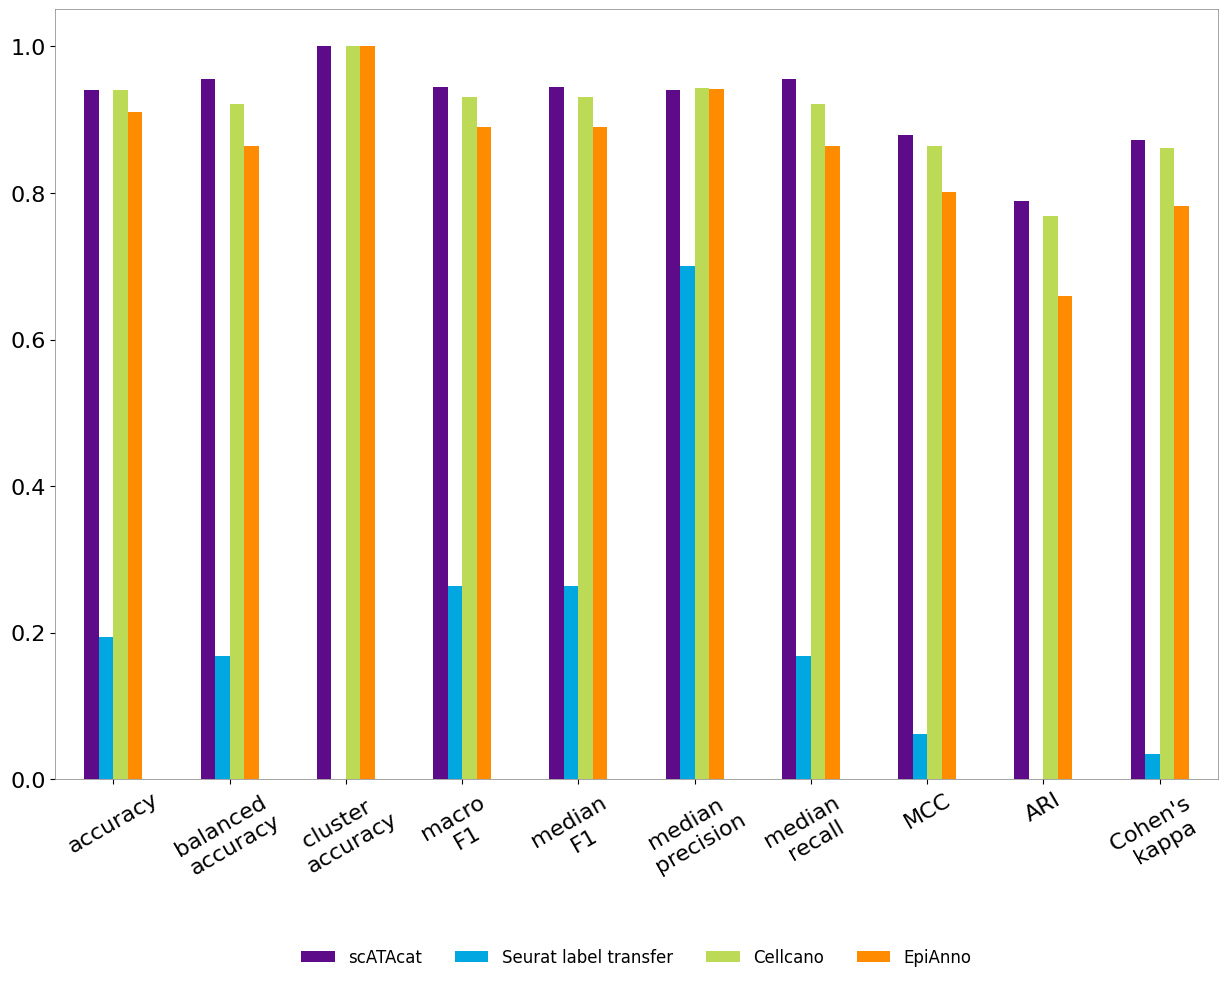

In [51]:
plot_performance_metrics(df = scores_df, save=True, tick_size=16, legend_fontsize=12, save_path=figures_dir+ '/common_cells_common_annotations.png',x_label_rotation=30)

## scores for common cells & pairwise common annotations


In [52]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"],
                        columns=["accuracy","balanced_accuracy","macroF1_score","medianF1_score","medianPrecision_score","medianRecall_score","mathews_corr_coef_score","adjusted_rand_score","cohens_kappa_score"])
common_cells = get_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,paper_metadata,Cellcano_annotations, EpiAnno_annotations)
all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,paper_metadata,Cellcano_annotations, EpiAnno_annotations, common_cells=common_cells, cell_ID_column = "cell_IDs")

common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations_simplified)
                          &set(all_methods_for_commonCells.label_transfer_annotations_simplified)
                          &set(all_methods_for_commonCells.Cellcano_annotations_simplified)
                         &set(all_methods_for_commonCells.EpiAnno_annotations_simplified))
all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]

correct_id_col = 'ground_truth_annotations_simplified'
cluster_id_column ='leiden_1.0'
for method in scores_df.index:
    if method == "scATAcat":
        common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "scATAcat_annotation"
        scores_df.loc["scATAcat", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["scATAcat", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Seurat_label_transfer":
        common_annotations = list(set(all_methods_for_commonCells.label_transfer_annotations_simplified)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations        
        predicted_id_col = "label_transfer_annotations_simplified"
        scores_df.loc["Seurat_label_transfer", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Seurat_label_transfer", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Cellcano":
        common_annotations = list(set(all_methods_for_commonCells.Cellcano_annotations_simplified)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "Cellcano_annotations_simplified"
        scores_df.loc["Cellcano", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Cellcano", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "EpiAnno":
        common_annotations = list(set(all_methods_for_commonCells.EpiAnno_annotations_simplified)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "EpiAnno_annotations_simplified"
        scores_df.loc["EpiAnno", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["EpiAnno", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)


In [53]:
scores_df

,accuracy,balanced_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score,cluster_accuracy
scATAcat,0.943662,0.97037,0.926182,0.93617,0.88,1.0,0.896906,0.80904,0.891851,1.0
Seurat_label_transfer,0.219178,0.271338,0.159444,0.135556,0.363333,0.167677,0.080894,-0.028195,0.049566,0.0
Cellcano,0.929577,0.863805,0.902714,0.904762,0.95,0.863636,0.856963,0.757133,0.853849,1.0
EpiAnno,0.910448,0.863636,0.889803,0.889803,0.941176,0.863636,0.801069,0.659615,0.781759,1.0


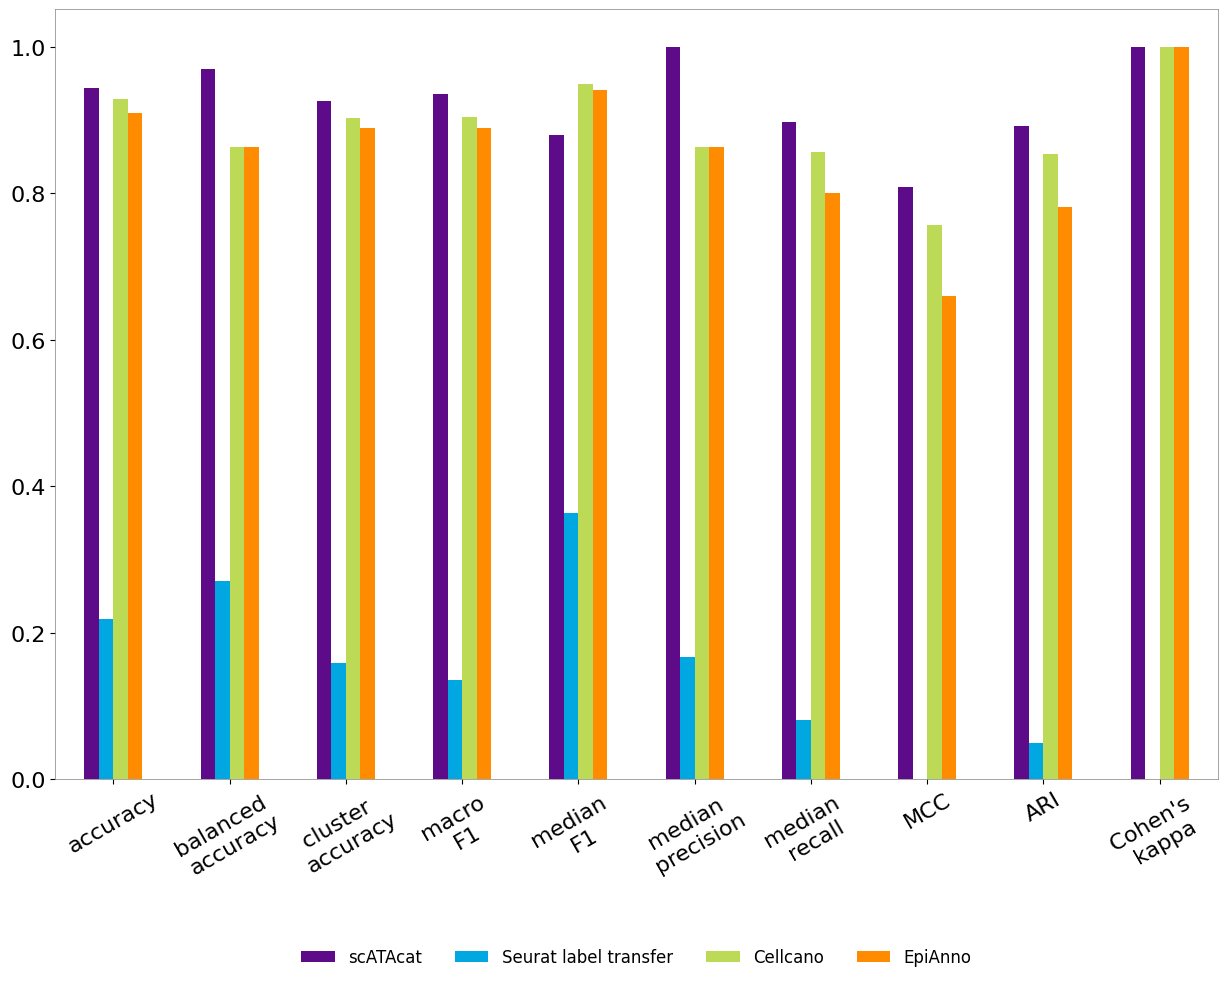

In [54]:
plot_performance_metrics(df = scores_df, save=True, tick_size=16, legend_fontsize=12, save_path=figures_dir+ '/common_cells_pairwise_common_annotations.png',x_label_rotation=30)